# Optimizing trayectories of Omnibot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor
plt.rcParams.update({'font.size': 15})

In [2]:
from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

In [3]:
from sympy import sqrt

In [4]:
init_vprinting()

### Using the symbolic formulas to generate the numeric model

In [5]:
def generic_omnibot_mats(n = 4, null_beta = True, equal_r = True):
    t, r, d, s = symbols('t r d s')
    alpha, beta= dynamicsymbols('alpha beta')
    
    W = Matrix([
        [r, cos(alpha)],
        [0, sin(alpha)]
    ])
    T = Matrix([
        [cos(beta), -sin(beta)],
        [sin(beta), cos(beta)]
    ])
    A = Matrix([
        [1, 0, -d],
        [0, 1, s]
    ])
    WTA= W.inv()@T.inv()@A
    WTA.simplify()
    r_n = WTA[0,:]
    s_n = WTA[1,:]
    
    R_list = []
    S_list = []
    
    for ii in range(n):
        r_ii = r_n.subs(alpha, symbols('alpha_'+str(ii+1)))
        r_ii = r_ii.subs(d, symbols('d_'+str(ii+1)))
        r_ii = r_ii.subs(s, symbols('s_'+str(ii+1)))
        s_ii = s_n.subs(alpha, symbols('alpha_'+str(ii+1)))
        s_ii = s_ii.subs(d, symbols('d_'+str(ii+1)))
        s_ii = s_ii.subs(s, symbols('s_'+str(ii+1)))
        if not equal_r:
            r_ii = r_ii.subs(r, symbols('r_'+str(ii+1)))
            s_ii = s_ii.subs(r, symbols('r_'+str(ii+1)))
        if null_beta:
            r_ii = r_ii.subs(beta, 0)
            s_ii = s_ii.subs(beta, 0)
        else:
            r_ii = r_ii.subs(beta, symbols('beta_'+str(ii+1)))
            s_ii = s_ii.subs(beta, symbols('beta_'+str(ii+1)))
            
        S_list.append(s_ii)
        R_list.append(r_ii)
    
    R = Matrix(R_list)
    S = Matrix(S_list)
    return R, S

In [6]:
def integerize(expr):
    expr2 = expr
    for a in preorder_traversal(expr):
        if isinstance(a, Float):
            expr2 = expr2.subs(a, round(a))
    return expr2

def roundize(expr,n = 4):
    expr2 = expr
    for a in preorder_traversal(expr):
        if isinstance(a, Float):
            expr2 = expr2.subs(a, round(a,n))
    return expr2

In [7]:
def dejabot_mats():
    R, S = generic_omnibot_mats()
    L, l = symbols('L l')
    for ii in range(4):
        alpha = pi/4 * (1 - 2 * ((int((ii+1)/2))%2))
        s = L * (1 - 2 * ((int((ii)/2))%2))
        d = l * (1 - 2 * (ii%2))
        R[ii,:] = R[ii,:].subs(symbols('alpha_'+str(ii+1)), alpha)
        R[ii,:] = R[ii,:].subs(symbols('s_'+str(ii+1)), s)
        R[ii,:] = R[ii,:].subs(symbols('d_'+str(ii+1)), d)
        S[ii,:] = S[ii,:].subs(symbols('alpha_'+str(ii+1)), alpha)
        S[ii,:] = S[ii,:].subs(symbols('s_'+str(ii+1)), s)
        S[ii,:] = S[ii,:].subs(symbols('d_'+str(ii+1)), d)
    return integerize(R), integerize(S)

In [8]:
def dejabot_mats_2():
    R, S = generic_omnibot_mats(null_beta=False)
    L, l = symbols('L_2 l_2')
    s_list = [l, L, -L, l]
    d_list = [L, l, -l, -L]
    for ii in range(4):
        alpha = pi/4 * (1 - 2 * ((int((ii+1)/2))%2))
        s = s_list[ii]
        d = d_list[ii]
        R[ii,:] = R[ii,:].subs(symbols('alpha_'+str(ii+1)), alpha)
        R[ii,:] = R[ii,:].subs(symbols('s_'+str(ii+1)), s)
        R[ii,:] = R[ii,:].subs(symbols('d_'+str(ii+1)), d)
        R[ii,:] = R[ii,:].subs(symbols('beta_'+str(ii+1)), pi/4)
        S[ii,:] = S[ii,:].subs(symbols('alpha_'+str(ii+1)), alpha)
        S[ii,:] = S[ii,:].subs(symbols('s_'+str(ii+1)), s)
        S[ii,:] = S[ii,:].subs(symbols('d_'+str(ii+1)), d)
        S[ii,:] = S[ii,:].subs(symbols('beta_'+str(ii+1)), pi/4)
    return integerize(R), integerize(S)

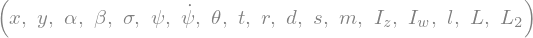

In [9]:
t, r, d, s, m, I_z, I_w, l, L, L_2 = symbols('t r d s m I_z I_w l L L_2')
x, y, alpha, beta, sigma, psi, theta= dynamicsymbols('x y alpha beta sigma psi theta')
psi_dot = psi.diff()
x, y, alpha, beta, sigma, psi, psi_dot, theta, t, r, d, s, m, I_z, I_w, l, L, L_2

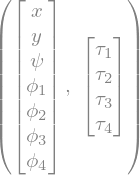

In [10]:
q = [x, y, psi] + [dynamicsymbols(f'phi_{i+1}') for i in range(4)]
q_r = Matrix([x, y, psi])
q = Matrix(q)
Gamma = [dynamicsymbols(f'tau_{i+1}') for i in range(4)]
Gamma = Matrix(Gamma)

q, Gamma

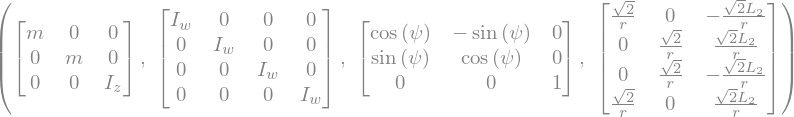

In [11]:
M_w = eye(4)*I_w
M_r = Matrix([
    [m, 0, 0],
    [0, m, 0],
    [0, 0, I_z]
])
R_psi = Matrix([
    [cos(psi), -sin(psi), 0],
    [sin(psi), cos(psi), 0],
    [0, 0, 1]
])
R, S = dejabot_mats_2()

M_r, M_w, R_psi, R

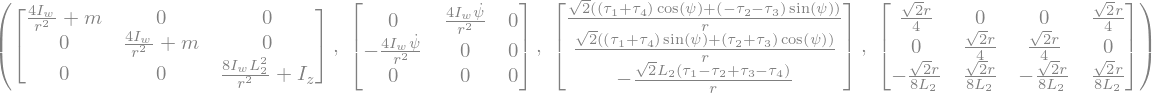

In [66]:
H = M_r + R_psi@R.T@M_w@R@R_psi.T
H = simplify(H)
K = R_psi@R.T@M_w@R@R_psi.diff().T
K = simplify(K)
F_a = R_psi@R.T@Gamma
F_a_0 = F_a[0].factor(sin(psi), cos(psi))
F_a_1 = F_a[1].factor(sin(psi), cos(psi))
F_a_2 = F_a[2].factor()
F_a = Matrix([F_a_0, F_a_1, F_a_2])
#A = R_psi@R.T COMPROBAR
H_inv = simplify(H.inv())
R_inv = simplify(R.pinv())
H, K, F_a, R_inv#A

In [13]:
get_h_raw = lambdify([m, I_w, I_z, L_2, r], H)
get_k_raw = lambdify([I_w, r, psi_dot], K)
get_a_raw = lambdify([psi, L_2, r], A)
get_h_inv_raw = lambdify([m, I_w, I_z, L_2, r], H_inv)

## Energy and Direction Study

![Esquema de Omnibot](images_dejabot/Omnibot_con_gamma.png)

#### Parameter encoding in functions:
$$Geom = [l, L, r]$$
$$Mass = [m, I_w,I_z]$$
$$q = [x, y, \psi]$$ where q is $q_r$

In [14]:
def get_h(geom, mass):
    l, L, r = geom
    m, I_w, I_z = mass
    L_2 = (L+l)/(2**0.5)
    return get_h_raw(m, I_w, I_z, L_2, r)

def get_k(geom, mass, q_dot):
    l, L, r = geom
    m, I_w, I_z = mass
    x_dot, y_dot, psi_dot = q_dot
    return get_k_raw(I_w, r, psi_dot)

def get_a(geom, q):
    l, L, r = geom
    x, y, psi = q
    L_2 = (L+l)/(2**0.5)
    return get_a_raw(psi, L_2, r)

def get_h_inv(geom, mass):
    l, L, r = geom
    m, I_w, I_z = mass
    L_2 = (L+l)/(2**0.5)
    return get_h_inv_raw(m, I_w, I_z, L_2, r)


In [15]:
geom = [0.2096, 0.2096, 0.0667]
mass = [15.75, 0.00266, 0.461]
q_0 = np.array([0, 0, 0])

In [16]:
# L_2:
2**0.5 * 0.2096

In [17]:
A_arr = get_a(geom, q_0)
A_arr

array([[21.20260213, -0.        , -0.        , 21.20260213],
       [ 0.        , 21.20260213, 21.20260213,  0.        ],
       [-6.28485757,  6.28485757, -6.28485757,  6.28485757]])

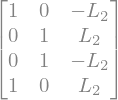

In [18]:
simplify(R*r/(sqrt(2)))

### Relationship between the speeds of the wheels and the speed of the center of mass

In [19]:
gamma_arr = np.linspace(0, np.pi, 200)
x_speed = np.cos(gamma_arr)
y_speed = np.sin(gamma_arr)
psi_speed = np.zeros_like(x_speed)

speed_vect = np.array([x_speed, y_speed, psi_speed])
wheel_speed_vect = A_arr.T @ speed_vect

Text(0, 0.5, '$\\phi_i$, in radians/s')

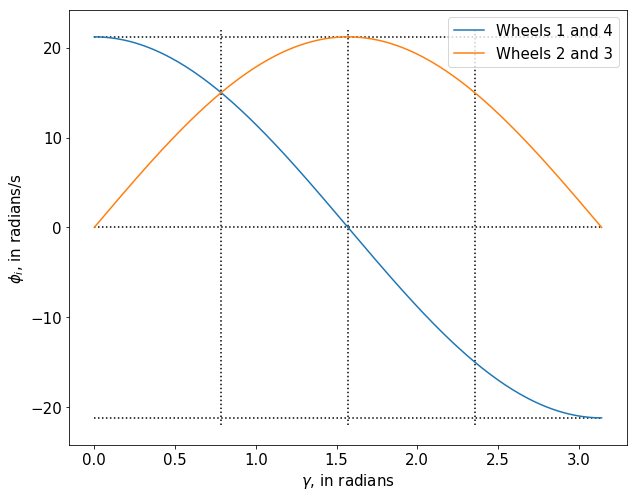

In [20]:
plt.figure(figsize=[10,8])
plt.plot(gamma_arr, wheel_speed_vect[0,:], label = 'Wheels 1 and 4')#ruedas 1 y 4
plt.plot(gamma_arr, wheel_speed_vect[1,:], label = 'Wheels 2 and 3') #ruedas 
plt.hlines([0, wheel_speed_vect[0,0], -wheel_speed_vect[0,0]], 0, np.pi, 'k', 'dotted')
plt.vlines(np.pi*np.array([0.25, 0.5, 0.75]), -22, 22, 'k', 'dotted')
plt.legend()
plt.xlabel('$\gamma$, in radians')
plt.ylabel('$\phi_i$, in radians/s')

Text(0, 0.5, '$\\phi_i$, in radians/s')

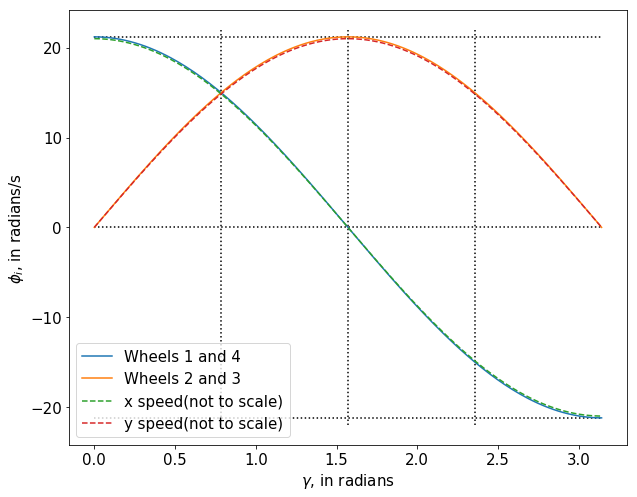

In [21]:
plt.figure(figsize=[10,8])
plt.plot(gamma_arr, wheel_speed_vect[0,:], label = 'Wheels 1 and 4')#ruedas 1 y 4
plt.plot(gamma_arr, wheel_speed_vect[1,:], label = 'Wheels 2 and 3') #ruedas 
plt.plot(gamma_arr, x_speed*21, '--', label = 'x speed(not to scale)')
plt.plot(gamma_arr, y_speed*21, '--', label = 'y speed(not to scale)')
plt.hlines([0, wheel_speed_vect[0,0], -wheel_speed_vect[0,0]], 0, np.pi, 'k', 'dotted')
plt.vlines(np.pi*np.array([0.25, 0.5, 0.75]), -22, 22, 'k', 'dotted')
plt.legend()
plt.xlabel('$\gamma$, in radians')
plt.ylabel('$\phi_i$, in radians/s')

Text(0, 0.5, '$abs(\\phi_i)$, in radians/s')

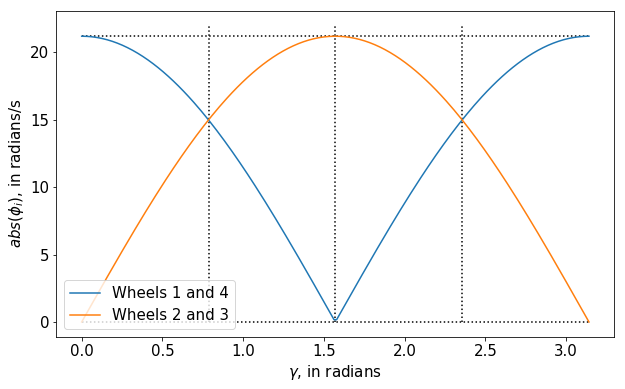

In [22]:
plt.figure(figsize=[10,6])
plt.plot(gamma_arr, np.abs(wheel_speed_vect[0,:]), label = 'Wheels 1 and 4')#ruedas 1 y 4
plt.plot(gamma_arr, np.abs(wheel_speed_vect[1,:]), label = 'Wheels 2 and 3') #ruedas 
plt.hlines([0, wheel_speed_vect[0,0]], 0, np.pi, 'k', 'dotted')
plt.vlines(np.pi*np.array([0.25, 0.5, 0.75]), 0, 22, 'k', 'dotted')
plt.legend()
plt.xlabel('$\gamma$, in radians')
plt.ylabel('$abs(\phi_i)$, in radians/s')

For $\gamma$ between $\pi/4$ and $3\pi/4$, wheels 2 and 3 are the limit. Outside, wheels 1 and 4 are the limit.


Movimiento estacionario: $$\dot{q_r} = v_r\left[\begin{matrix}\operatorname{cos}\left(\gamma\right)\\\operatorname{sin}\left(\gamma\right)\\0\end{matrix}\right]$$

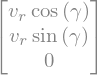

In [23]:
gamma = symbols('gamma')
v_r = symbols('v_r')
q_d_unit = Matrix([cos(gamma), sin(gamma), 0])
q_d_r_sta = v_r * q_d_unit.copy()
q_d_r_sta

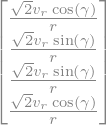

In [24]:
q_d_w_sta = simplify(R @ q_d_r_sta)
q_d_w_sta

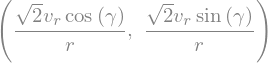

In [25]:
w_1_phi_dot, w_2_phi_dot,_,_ =  q_d_w_sta
w_1_phi_dot, w_2_phi_dot

In [26]:
phi_dot_max = 2 * np.pi * 7000/(49*60)
def max_speed_dir(gamma):
    '''Valid for gamma between 0 and pi'''
    phi_dot_max = 2 * np.pi * 7000/(49*60)
    r = 0.0667
    v_r_w_1 = np.abs(phi_dot_max * r/(2**0.5 * np.cos(gamma)))
    v_r_w_2 = np.abs(phi_dot_max * r/(2**0.5 * np.sin(gamma)))
    v_r = np.where(gamma < np.pi/4, v_r_w_1, v_r_w_2)
    v_r = np.where(3*np.pi/4 < gamma, v_r_w_1, v_r)
     
    return v_r

C:\ProgramData\Anaconda3\envs\iri\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


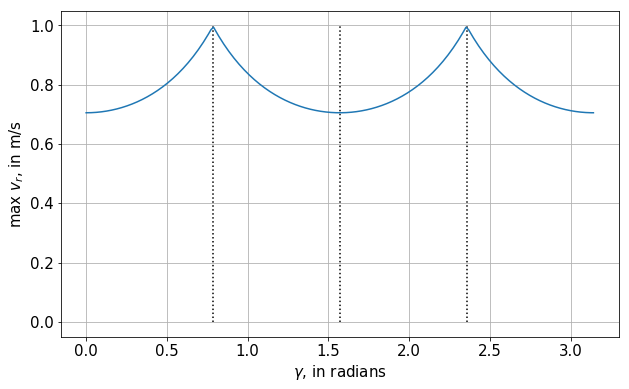

In [27]:
plt.figure(figsize=[10,6])
plt.plot(gamma_arr, max_speed_dir(gamma_arr), label = 'Wheels 2 and 3') #ruedas 
#plt.hlines([0, wheel_speed_vect[0,0]], 0, np.pi, 'k', 'dotted')
plt.vlines(np.pi*np.array([0.25, 0.5, 0.75]), 0, 1, 'k', 'dotted')
plt.xlabel('$\gamma$, in radians')
plt.ylabel('max $v_r$, in m/s')
plt.grid()

#### Lets work with in coordinate system 2

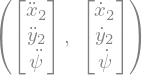

In [28]:
x_2, y_2 = dynamicsymbols('x_2 y_2')
q_d = Matrix([x_2, y_2, psi]).diff()
q_d_d = q_d.diff()
q_d_d, q_d

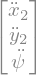

In [29]:
q_d_d

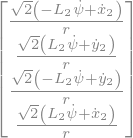

In [30]:
q_d_w = simplify(R @ q_d)
q_d_w

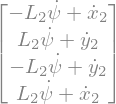

In [31]:
simplify(q_d_w*r/(sqrt(2)))

In [32]:
def max_speed_axes_2(psi_dot):
    L_2 = 0.29642
    r = 0.0667
    phi_dot_max = 2 * np.pi * 7000/(49*60)
    return(phi_dot_max * r/(2**0.5) - np.abs(L_2 * psi_dot))

In [33]:
phi_dot_max = 2 * np.pi * 7000/(49*60)
psi_dot_max = phi_dot_max * 0.0667/(2**0.5 * 0.29642)
psi_dot_max

In [34]:
from matplotlib import cm

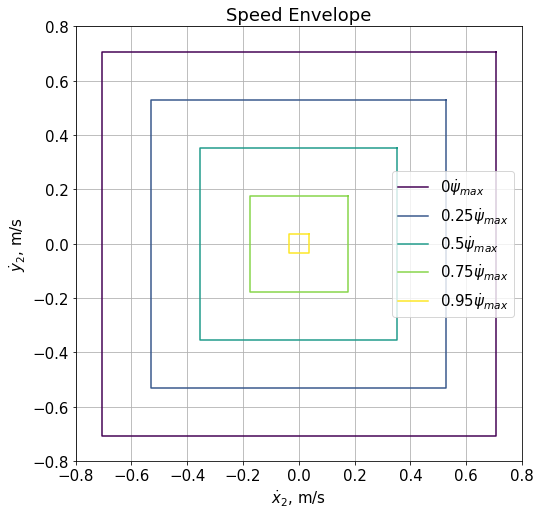

In [37]:
percent = [0, 0.25, 0.5, 0.75, 0.95]
viridis = cm.get_cmap('viridis', 12)

fig, ax = plt.subplots(figsize = [8,8])
ax.set_title('Speed Envelope', picker=True)

ax.set_xlim([-0.8, 0.8])
ax.set_ylim([-0.8, 0.8])
ax.set_xlabel('$\dot{x}_2$, m/s')
ax.set_ylabel('$\dot{y}_2$, m/s')

for ii in percent:
    psi_val = ii * psi_dot_max
    mx_spd = max_speed_axes_2(psi_val)

    x_coord = [mx_spd, mx_spd, -mx_spd, -mx_spd, mx_spd]
    y_coord = [mx_spd, -mx_spd, -mx_spd, mx_spd, mx_spd]
    plt.plot(x_coord, y_coord, color = viridis(ii), label = str(ii)+'$\dot{\psi}_{max}$')
plt.grid()
plt.legend()

## Electric considerations

 Electric Motor Model

$$ V = K_m N\dot{\phi} + Ri$$
$$ \tau_m = N K_ei\mu_{trans} - \tau_r$$

$$ \tau_r = a \dot{\phi} + b·sign(\dot{\phi}) $$

In [38]:
a, b, k_e, k_m, n, r_e = symbols('a b K_e K_m N R_e')
a, b, k_e, k_m, n, r_e

In [39]:
from sympy.functions import sign

Movimiento en uniforme en ejes 2: : $$\dot{q_2} = \left[\begin{matrix}\dot{x_2}\\\dot{y_2}\\0\end{matrix}\right]$$

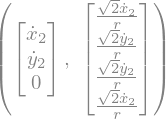

In [40]:
q_d = Matrix([x_2, y_2, 0]).diff()
q_d_d = q_d.diff()
q_d_w = simplify(R @ q_d)
q_d, q_d_w

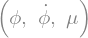

In [41]:
phi = dynamicsymbols('\phi')
n = symbols('n')
mu = symbols('\mu')
phi_dot = diff(phi)
phi, phi_dot, mu

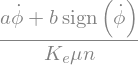

In [42]:
i = (a * phi_dot + b * sign(phi_dot))/(k_e * mu * n)
i

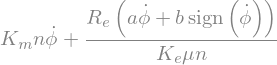

In [43]:
v = k_m * n * phi_dot + r_e * i
v

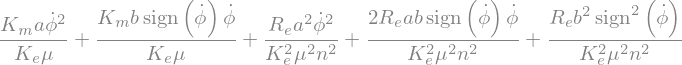

In [44]:
pow_e = expand(i*v)
pow_e

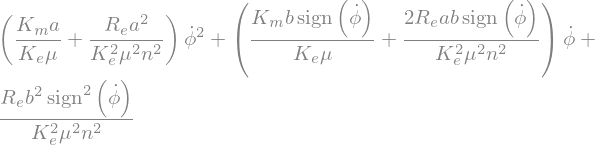

In [45]:
#pow_e = pow_e.replace(sign(phi_dot)**2, 1)
#pow_e_simp = collect(pow_e.replace(sign(phi_dot), 1), phi_dot)
pow_e_simp = collect(pow_e, phi_dot)
pow_e_simp

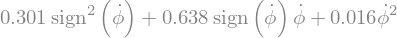

In [46]:
pow_e_simp_num = pow_e_simp.subs(a, 0.01).subs(b, 0.4).subs(k_e, 0.0337).subs(k_m, 0.03148).subs(r_e, 1.84615).subs(n, 49).subs(mu, 0.6)
roundize(pow_e_simp_num,3)

In [47]:
pow_e_simp_f = lambdify([phi_dot], pow_e_simp_num)

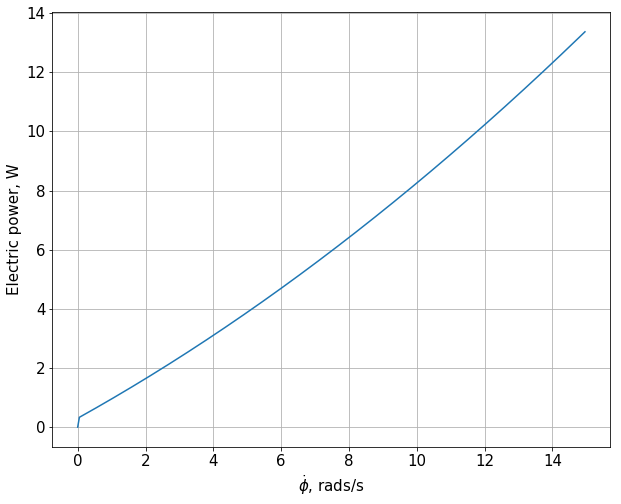

In [48]:
x = np.linspace(0, 2 * np.pi * 7000/(49*60), 300)
plt.figure(figsize=[10,8])
p=pow_e_simp_f(x)
plt.plot(x, p)  
plt.xlabel('$\dot{\phi}$, rads/s')
plt.ylabel('Electric power, W')
plt.grid(True)

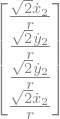

In [57]:
q_d_w

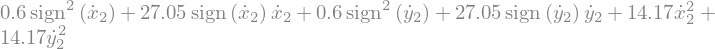

In [50]:
total_p = 0
for iii in range(4):
    total_p += pow_e_simp_num.subs(phi_dot, q_d_w[iii])
total_p = simplify(total_p.subs(sqrt(2),2**0.5).subs(r, 0.0667).subs(L_2, 0.29642))
roundize(total_p, 2)

In [51]:
phi_dot_max = 2 * np.pi * 7000/(49*60)
phi_dot_max

In [52]:
total_p_fun = lambdify([x_2.diff(), y_2.diff()], total_p)

In [53]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, Circle

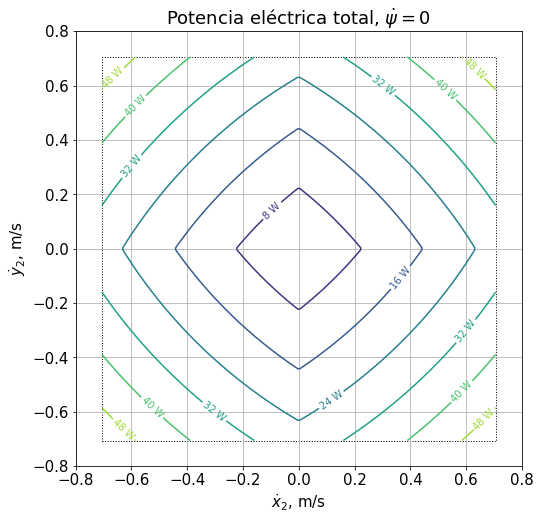

In [54]:
percent = [0, 0.25, 0.5, 0.75]


#plt.figure(figsize = [10,8])

psi_val = percent[0]
mx_spd = max_speed_axes_2(psi_val)
speed_arr = np.linspace(-mx_spd, mx_spd, 200)
xx_speed, yy_speed = np.meshgrid(speed_arr, speed_arr)
xy_power = total_p_fun(xx_speed, yy_speed)

fig, ax = plt.subplots(figsize = [8,8])
ax.set_title('Potencia eléctrica total, $\dot{\psi} = 0$', picker=True)
CS = ax.contour(speed_arr, speed_arr, xy_power)
ax.clabel(CS, inline=1, fontsize=10, fmt = '%i W')
ax.set_xlim([-0.8, 0.8])
ax.set_ylim([-0.8, 0.8])
ax.set_xlabel('$\dot{x}_2$, m/s')
ax.set_ylabel('$\dot{y}_2$, m/s')
rect = Rectangle((-mx_spd,-mx_spd), 2*mx_spd, 2*mx_spd, fill=False, linestyle = ':')
#pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,edgecolor=edgecolor)

ax.add_patch(rect)
#plt.contour(speed_arr, speed_arr, xy_power)

#for per in percent:
#    plt.plot(gamma_arr,total_p_fun(gamma_arr, v_r_num* per), label = '$v_r$ = '+ str(per) + '$v_{r,max}$')
#plt.vlines(np.pi*np.array([0.25, 0.5, 0.75]), 0, 36, 'k', 'dotted')
plt.grid()
#plt.legend()
#plt.xlabel('$\gamma$, in radians')
#plt.ylabel('Total power, in W')

# Projection on axes 2

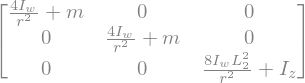

In [58]:
H

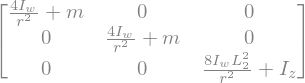

In [59]:
simplify(R_psi.T @ H @ R_psi)

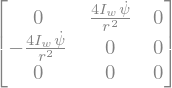

In [60]:
K

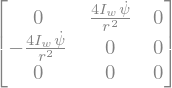

In [61]:
simplify(R_psi.T @ K @ R_psi)

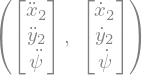

In [62]:
q_d_2 = Matrix([x_2, y_2, psi]).diff()
q_d_d_2 = q_d_2.diff()
q_d_d_2, q_d_2

Case without acceleration: $\ddot{q}_2 = 0$

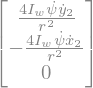

In [63]:
K @ q_d_2

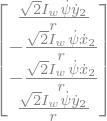

In [67]:
Gamma_unif_2 = simplify(R_inv.T @ K @ q_d_2)
Gamma_unif_2

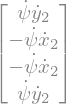

In [84]:
Gamma_unif_2*r/sqrt(2)/I_w

In [68]:
tau_m = symbols('tau_m')
tau_m

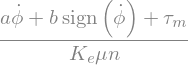

In [69]:
i = (tau_m + a * phi_dot + b * sign(phi_dot))/(k_e * mu * n)
i

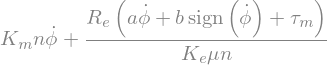

In [70]:
v = k_m * n * phi_dot + r_e * i
v

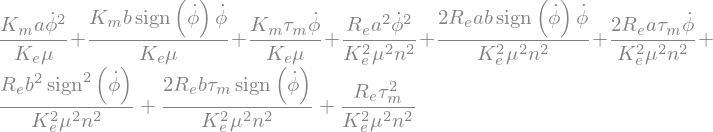

In [71]:
pow_e = expand(i*v)
pow_e

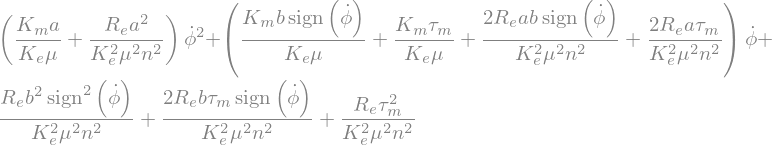

In [72]:
#pow_e = pow_e.replace(sign(phi_dot)**2, 1)
#pow_e_simp = collect(pow_e.replace(sign(phi_dot), 1), phi_dot)
pow_e_simp = collect(pow_e, phi_dot)
pow_e_simp

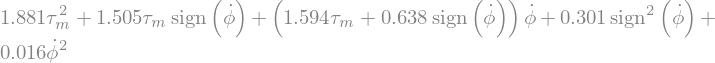

In [73]:
pow_e_simp_num = pow_e_simp.subs(a, 0.01).subs(b, 0.4).subs(k_e, 0.0337).subs(k_m, 0.03148).subs(r_e, 1.84615).subs(n, 49).subs(mu, 0.6)
roundize(pow_e_simp_num,3)

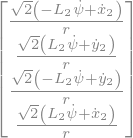

In [74]:
q_d_w_2 = simplify(R @ q_d_2)
q_d_w_2

In [75]:
I_w

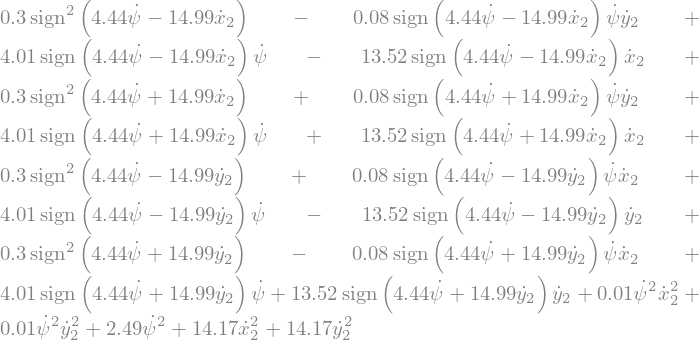

In [76]:
total_p = 0
for iii in range(4):
    total_p += pow_e_simp_num.subs(phi_dot, q_d_w_2[iii]).subs(tau_m, Gamma_unif_2[iii]).subs(I_w, 0.00266)
total_p = simplify(total_p.subs(sqrt(2),2**0.5).subs(r, 0.0667).subs(L_2, 0.29642))
roundize(total_p, 2)

In [77]:
total_p_fun = lambdify([x_2.diff(), y_2.diff(), psi_dot], total_p)

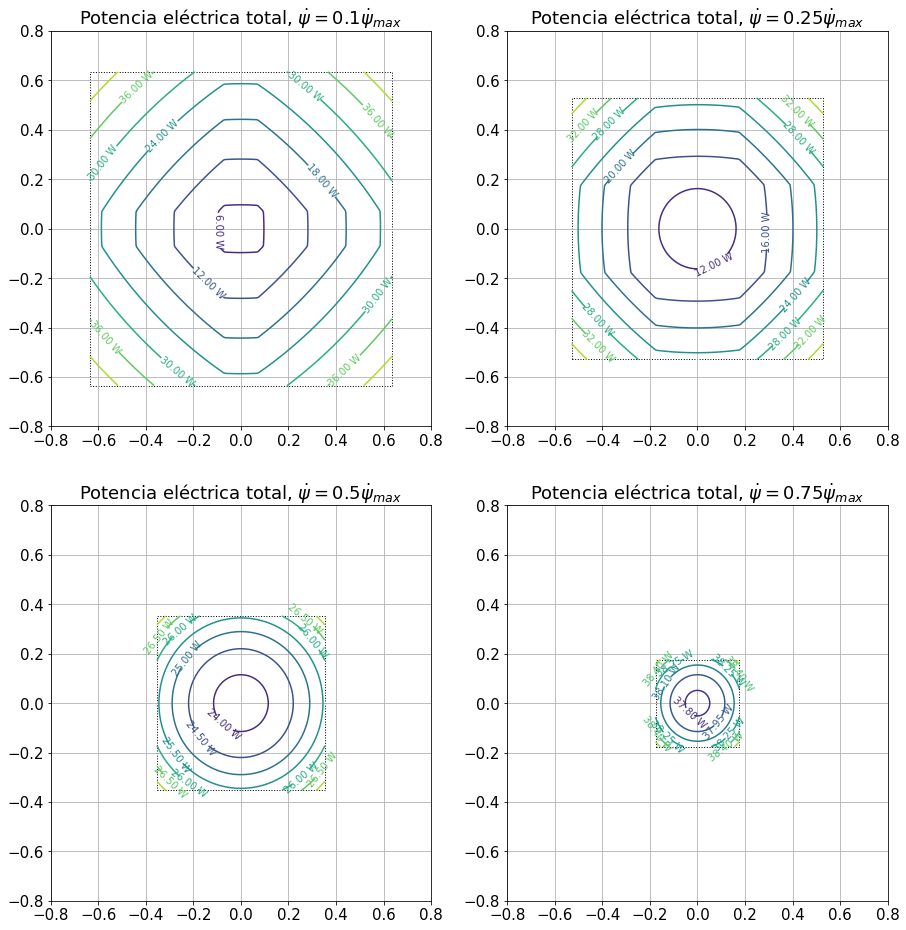

In [78]:
percent = [0.1, 0.25, 0.5, 0.75]


plt.figure(figsize = [15,16])

for iii in range(4):
    psi_val = percent[iii]*psi_dot_max
    mx_spd = max_speed_axes_2(psi_val)
    speed_arr = np.linspace(-mx_spd, mx_spd, 200)
    xx_speed, yy_speed = np.meshgrid(speed_arr, speed_arr)
    xy_power = total_p_fun(xx_speed, yy_speed, psi_val)

    ax = plt.subplot(2,2,iii+1)
    title = 'Potencia eléctrica total, $\dot{\psi} = '+ str(percent[iii])+'\dot{\psi}_{max}$'
    ax.set_title(title, picker=True)
    CS = ax.contour(speed_arr, speed_arr, xy_power)
    ax.clabel(CS, inline=1, fontsize=10, fmt = '%1.2f W')
    ax.set_xlim([-0.8, 0.8])
    ax.set_ylim([-0.8, 0.8])
    rect = Rectangle((-mx_spd,-mx_spd), 2*mx_spd, 2*mx_spd, fill=False, linestyle = ':')
    #pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,edgecolor=edgecolor)

    ax.add_patch(rect)
    #plt.contour(speed_arr, speed_arr, xy_power)

    #for per in percent:
    #    plt.plot(gamma_arr,total_p_fun(gamma_arr, v_r_num* per), label = '$v_r$ = '+ str(per) + '$v_{r,max}$')
    #plt.vlines(np.pi*np.array([0.25, 0.5, 0.75]), 0, 36, 'k', 'dotted')
    plt.grid()
#plt.legend()
#plt.xlabel('$\gamma$, in radians')
#plt.ylabel('Total power, in W')

In [98]:
6%5

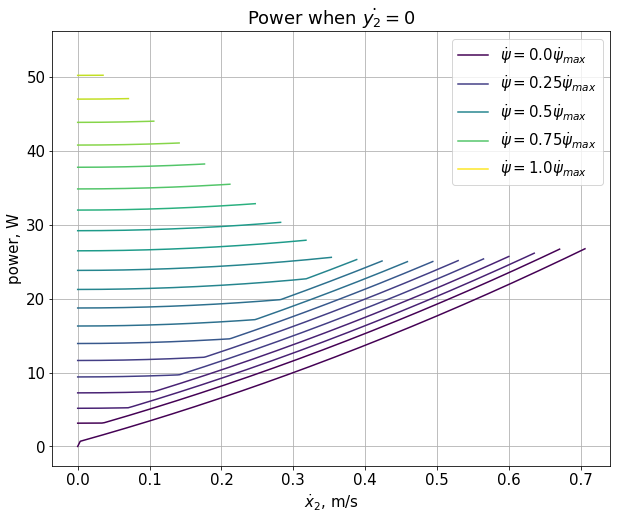

In [102]:
percent = np.linspace(0, 1, 21)
viridis = cm.get_cmap('viridis', 12)
plt.figure(figsize = [10,8])
for iii in range(len(percent)):
    psi_val = percent[iii]*psi_dot_max
    mx_spd = max_speed_axes_2(psi_val)
    speed_arr = np.linspace(0, mx_spd, 200)
    x_power = total_p_fun(speed_arr, 0, psi_val)
    if iii%5 == 0:
        title = '$\dot{\psi} = '+ str(round(percent[iii],2))+'\dot{\psi}_{max}$'
        plt.plot(speed_arr, x_power, color = viridis(iii/len(percent)),label = title)
    else:
        plt.plot(speed_arr, x_power, color = viridis(iii/len(percent)))
plt.legend()
plt.title('Power when $\dot{y_2}=0$')
plt.xlabel('$\dot{x}_2$, m/s')
plt.ylabel('power, W')
plt.grid()

0.705572123750388
0.6702935175628686
0.6350149113753492
0.5997363051878298
0.5644576990003104
0.5291790928127911
0.4939004866252716
0.45862188043775215
0.42334327425023277
0.3880646680627134
0.352786061875194
0.3175074556876745
0.28222884950015514
0.24695024331263576
0.21167163712511627
0.17639303093759695
0.14111442475007752
0.10583581856255808
0.07055721237503876
0.035278606187519324
0.0


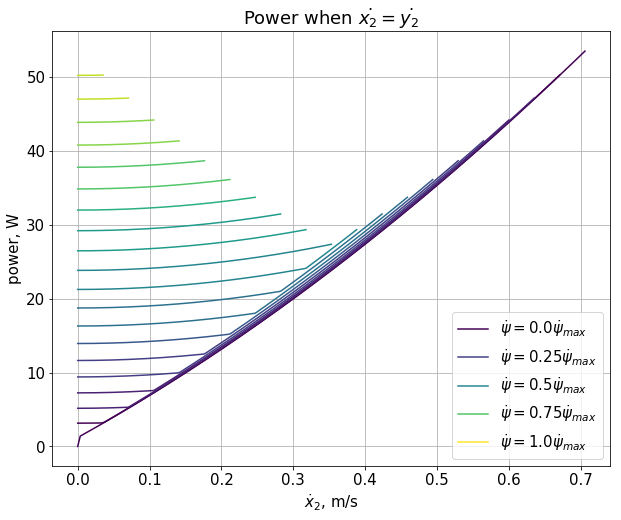

In [104]:
percent = np.linspace(0, 1, 21)
viridis = cm.get_cmap('viridis', 12)
plt.figure(figsize = [10,8])
for iii in range(len(percent)):
    psi_val = percent[iii]*psi_dot_max
    mx_spd = max_speed_axes_2(psi_val)
    speed_arr = np.linspace(0, mx_spd, 200)
    x_power = total_p_fun(speed_arr, speed_arr, psi_val)
    if iii%5 == 0:
        title = '$\dot{\psi} = '+ str(round(percent[iii],2))+'\dot{\psi}_{max}$'
        plt.plot(speed_arr, x_power, color = viridis(iii/len(percent)),label = title)
    else:
        plt.plot(speed_arr, x_power, color = viridis(iii/len(percent)))
plt.legend()
plt.title('Power when $\dot{x_2}=\dot{y_2}$')
plt.xlabel('$\dot{x}_2$, m/s')
plt.ylabel('power, W')
plt.grid()

## Electric Motor Model

$$ V = K_m \dot{\phi} + Ri$$
$$ \tau_m = K_ei - \tau_r$$

In [ ]:
def friction(a, b, phi_dot, V, eps_phi = 0.01):
    fric_wet = a * phi_dot
    fric_dry = np.where(npor(
        phi_dot>eps_phi,
        npand(
            np.abs(phi_dot)<=eps_phi,
            V > 0)
    ),b, 0)
    fric_dry = np.where(npor(
        phi_dot< -eps_phi,
        npand(
            np.abs(phi_dot)<=eps_phi,
            V < 0)
    ),-b, fric_dry)
    return fric_wet + fric_dry

In [ ]:
def create_motor_model(i_7000 = 0.5):
    V = 24
    R = 24/13
    K_m = (V - R*i_7000)/(2 * np.pi*7000/60)
    t_rat = 4300*9.8/(100*1000)    #570*9.8/(100*1000)
    phi_rat = 0                    #5900*np.pi*2/60
    i_rat = (V - K_m*phi_rat)/R
    K_e = t_rat/(i_rat-i_7000)
    t_r = -t_rat + K_e * i_rat
    print(f'K_m = {K_m}, K_e = {K_e}, R = {R}, i_rat = {i_rat}, t_r = {t_r}')
    def motor_model(phi_dot, V = 24):
        i = (V - K_m*phi_dot)/R
        t = K_e * i - friction(0,t_r, phi_dot, V)
        p = t * phi_dot
        ef = p / (i * V)
        return t, i, p, ef
    def simp_motor_model(phi_dot, V = 24):
        i = (V - K_m*phi_dot)/R
        t = K_e * i - friction(0,t_r, phi_dot, V)
        return t
    return motor_model, simp_motor_model

In [ ]:
x = np.linspace(0, 2 * np.pi * 7000/60, 300)
n = x * 30 / np.pi
motor_model = create_motor_model(0.5)[0]
t, i, p, ef = motor_model(x)
t = t *100000/9.8

fig, ax1 = plt.subplots()

ax1.plot(t,n)
ax1.set_ylim([0,7000])
ax1.set_xlim([0,4400])

ax2 = ax1.twinx()
ax2.plot(t,i)
ax2.set_ylim([0,13])

ax3 = ax1.twinx()
ax3.plot(t,p)
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_ylim([0,80])

ax4 = ax1.twinx()
ax4.plot(t,ef)
ax4.spines["right"].set_position(("axes", 1.2))
ax4.set_ylim([0,1])
plt.grid()
plt.title('Motor Curves')

plt.grid(True)

### Comparison with manufacturer original motor curves:
![Original curves](images_dejabot/curvas_motor.png)

Expanded curves outside normal regime:

In [ ]:
x = np.linspace(-2 * np.pi * 7000/60, 4 * np.pi * 7000/60, 300)
n = x * 30 / np.pi
motor_model = create_motor_model(0.5)[0]
t, i, p, ef = motor_model(x)
t = t *100000/9.8

fig, ax1 = plt.subplots()

ax1.plot(t,n, 'r')
ax1.set_ylim([-14000,14000])
ax1.set_xlim([-4400,8800])

ax2 = ax1.twinx()
ax2.plot(t,i)
ax2.set_ylim([-26,26])

ax3 = ax1.twinx()
ax3.plot(t,p)
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_ylim([-80,80])

ax4 = ax1.twinx()
ax4.plot(t,ef, 'g')
ax4.spines["right"].set_position(("axes", 1.2))
ax4.set_ylim([-2,2])
plt.grid()

plt.grid(True)

Adapted Curves with reductor gears:

## Electric Motor Model

$$ V = K_m \dot{\phi_{mot}} + Ri$$
$$ \tau_m = N K_ei\mu_{trans} - \tau_r$$

$$ \dot{\phi}_{mot} = N \dot{\phi}$$
$$ \tau_r = a \dot{\phi} + b·sign(\dot{\phi}) $$

In [ ]:
def create_motoreduct_model(i_7000 = 0.5, N = 49, eff = 0.6, a = 0.01, b = 0.4):
    V = 24
    R = 24/13
    K_m = (V - R*i_7000)/(2 * np.pi*7000/60)
    t_rat = 4300*9.8/(100*1000)    #570*9.8/(100*1000)
    phi_rat = 0                    #5900*np.pi*2/60
    i_rat = (V - K_m*phi_rat)/R
    K_e = t_rat/(i_rat-i_7000)
    
    print(f'K_m = {K_m}, K_e = {K_e}, R = {R}, i_rat = {i_rat}')
    eps_phi = 0.1
    
    def motoreduct_model(phi_dot, V = 24):
        phi_dot_motor = phi_dot * N
        i = (V - K_m*phi_dot_motor)/R
        t = K_e * i * N * eff - friction(a, b, phi_dot, V, eps_phi)
        p = t * phi_dot
        ef = p / (i * V)
        return t, i, p, ef
    def simp_motoreduct_model(phi_dot, V = 24):
        phi_dot_motor = phi_dot * N
        i = (V - K_m*phi_dot_motor)/R
        t = K_e * i * N * eff - friction(a, b, phi_dot, V, eps_phi)
        return t
    return motoreduct_model, simp_motoreduct_model

In [ ]:
x = np.linspace(0, 2 * np.pi * 7000/(49*60), 300)
n = x * 30 / np.pi
motor_model = create_motoreduct_model(0.5)[0]
t, i, p, ef = motor_model(x)
t = t *100000/9.8

fig, ax1 = plt.subplots()

ax1.plot(t,n)
ax1.set_ylim([0,150])
ax1.set_xlim([0,130000])

ax2 = ax1.twinx()
ax2.plot(t,i)
ax2.set_ylim([0,13])

ax3 = ax1.twinx()
ax3.plot(t,p)
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_ylim([0,80])

ax4 = ax1.twinx()
ax4.plot(t,ef)
ax4.spines["right"].set_position(("axes", 1.2))
ax4.set_ylim([0,1])
#plt.grid()

ax5 = ax1.twinx()
ax5.spines["right"].set_position(("axes", -0.2))
ax5.set_ylim([0, x[-1]*0.0667])

plt.grid(True)

In [ ]:
def torq_lims(phi_dot, v_max = 24, motor = create_motoreduct_model()[1]):
    t_max = motor(phi_dot, v_max)
    t_min = motor(phi_dot, -v_max)
    
    return t_max, t_min

In [ ]:
def vect_torq_lims(geom, q, q_dot):
    a = get_a(geom, q)
    phi_dot = a.T@q_dot
    #print(f'phi_dot: {np.round(phi_dot,3)}')
    t_max = []
    t_min = []
    for wheel in phi_dot:
        maxt, mint = torq_lims(wheel)
        t_max.append(maxt)
        t_min.append(mint)
    t_max = np.array(t_max)
    t_min = np.array(t_min)
    
    return (t_max, t_min)

### Simplified expression linking maximum and mínimum torque as function of speed

In [ ]:
phi_arr = np.linspace(-20, 20, 500)
max_t, min_t = torq_lims(phi_arr)
t_v_med, t_min_v_med = torq_lims(phi_arr, v_max= 12)
t_v_0, _ = torq_lims(phi_arr, v_max= 0)
max_t_nodry, min_t_nodry = torq_lims(phi_arr, motor = create_motoreduct_model(b=0)[1])
t_v_med_nodry, t_min_v_med_nodry = torq_lims(phi_arr, v_max= 12, motor = create_motoreduct_model(b=0)[1])
t_v_0_nodry, _ = torq_lims(phi_arr, v_max= 0, motor = create_motoreduct_model(b=0)[1])

In [ ]:
plt.figure(figsize=[15,12])
n_arr = phi_arr * 30 / np.pi 
plt.plot(n_arr, max_t*100/9.8, label = 'par máximo, modelo completo')
plt.plot(n_arr, min_t*100/9.8, label = 'par mínimo, modelo completo')
plt.plot(n_arr, max_t_nodry*100/9.8, label = 'par máximo, sin fricción seca')
plt.plot(n_arr, min_t_nodry*100/9.8, label = 'par mínimo, sin fricción seca')
plt.plot(n_arr, t_v_med*100/9.8, label = 'par a 12 V, modelo completo')
plt.plot(n_arr, t_min_v_med*100/9.8, label = 'par a -12 V, modelo completo')
plt.plot(n_arr, t_v_med_nodry*100/9.8, label = 'par a 12 V, sin fricción seca')
plt.plot(n_arr, t_min_v_med_nodry*100/9.8, label = 'par a -12 V, sin fricción seca')
plt.plot(n_arr, t_v_0*100/9.8, label = 'par a 0 V, modelo completo')
plt.plot(n_arr, t_v_0_nodry*100/9.8, label = 'par a 0 V, sin fricción seca')
plt.hlines(0, -200, 200, 'k', 'dotted')
plt.vlines(0, -300, 300, 'k', 'dotted')
plt.grid
plt.xlabel('velocidad del motor, RPM')
plt.ylabel('par motor, Kg·cm')
plt.legend()

In [ ]:
def cutpoint(x1, x2, y1, y2):
    a = (y1-y2)/(x1-x2)
    b = y1 - a * x1
    return -b/a

In [ ]:
cut1 = cutpoint(phi_arr[260], phi_arr[499], max_t[260], max_t[499])
cut2 = cutpoint(phi_arr[260], phi_arr[499], max_t_nodry[260], max_t_nodry[499])
corr_factor = cut2/cut1
corr_factor

In [ ]:
cut1

In [ ]:
new_a = 0.4/cut1 + 0.01
new_a

In [ ]:
friction(0.01, 0.4, cut1, 24)

In [ ]:
friction(new_a , 0.0, cut1, 24)

new_a = (corr_factor -1)* 0.0314812 / 1.846154 + corr_factor* 0.01
new_a

In [ ]:
max_t_new_m, min_t_new_m = torq_lims(phi_arr, motor = create_motoreduct_model(b=0, a=new_a)[1])
t_v_med_new_m, t_min_v_med_new_m = torq_lims(phi_arr, v_max= 12, motor = create_motoreduct_model(b=0, a=new_a)[1])
t_v_0_new_m, _ = torq_lims(phi_arr, v_max= 0, motor = create_motoreduct_model(b=0, a=new_a)[1])

In [ ]:
plt.figure(figsize=[15,12])
n_arr = phi_arr * 30 / np.pi 
plt.plot(n_arr, max_t*100/9.8, label = 'par máximo, modelo completo')
plt.plot(n_arr, min_t*100/9.8, label = 'par mínimo, modelo completo')
plt.plot(n_arr, max_t_new_m*100/9.8, label = 'par máximo, modificado')
plt.plot(n_arr, min_t_new_m*100/9.8, label = 'par mínimo, modificado')
plt.plot(n_arr, t_v_med*100/9.8, label = 'par a 12 V, modelo completo')
plt.plot(n_arr, t_min_v_med*100/9.8, label = 'par a -12 V, modelo completo')
plt.plot(n_arr, t_v_med_new_m*100/9.8, label = 'par a 12 V, modificado')
plt.plot(n_arr, t_min_v_med_new_m*100/9.8, label = 'par a -12 V, modificado')
plt.plot(n_arr, t_v_0*100/9.8, label = 'par a 0 V, modelo completo')
plt.plot(n_arr, t_v_0_new_m*100/9.8, label = 'par a 0 V, modificado')
plt.hlines(0, -200, 200, 'k', 'dotted')
plt.vlines(0, -300, 300, 'k', 'dotted')
plt.grid
plt.xlabel('velocidad del motor, RPM')
plt.ylabel('par motor, Kg·cm')
plt.legend()

In [ ]:
max_t_no_f, min_t_no_f = torq_lims(phi_arr, motor = create_motoreduct_model(b=0, a=0)[1])
t_v_med_no_f, t_min_v_med_no_f = torq_lims(phi_arr, v_max= 12, motor = create_motoreduct_model(b=0, a=0)[1])
t_v_0_no_f, _ = torq_lims(phi_arr, v_max= 0, motor = create_motoreduct_model(b=0, a=0)[1])

In [ ]:
plt.figure(figsize=[15,12])
n_arr = phi_arr * 30 / np.pi 
plt.plot(n_arr, max_t*100/9.8, label = 'par máximo, modelo completo')
plt.plot(n_arr, min_t*100/9.8, label = 'par mínimo, modelo completo')
plt.plot(n_arr, max_t_no_f*100/9.8, label = 'par máximo, sin rozamiento')
plt.plot(n_arr, min_t_no_f*100/9.8, label = 'par mínimo, sin rozamiento')
plt.plot(n_arr, t_v_med*100/9.8, label = 'par a 12 V, modelo completo')
plt.plot(n_arr, t_min_v_med*100/9.8, label = 'par a -12 V, modelo completo')
plt.plot(n_arr, t_v_med_no_f*100/9.8, label = 'par a 12 V, sin rozamiento')
plt.plot(n_arr, t_min_v_med_no_f*100/9.8, label = 'par a -12 V, sin rozamiento')
plt.plot(n_arr, t_v_0*100/9.8, label = 'par a 0 V, modelo completo')
plt.plot(n_arr, t_v_0_no_f*100/9.8, label = 'par a 0 V, sin rozamiento')
plt.hlines(0, -200, 200, 'k', 'dotted')
plt.vlines(0, -300, 300, 'k', 'dotted')
plt.grid
plt.xlabel('velocidad del motor, RPM')
plt.ylabel('par motor, Kg·cm')
plt.legend()